In [46]:
from typing import List, NoReturn, Tuple

import matplotlib.pyplot as plt
import nltk
import numpy as np
import torch
from nltk.corpus import stopwords
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline

In [2]:
recording = "rec.mp3"
output_file = "transcription.txt"

## Pipeline setup

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "openai/whisper-large-v3"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    torch_dtype=torch_dtype,
    device=device,
    return_timestamps=True,
    generate_kwargs={"language": "russian"},
)

Device set to use cuda:0


## Preprocessing of the recording and data extraction

### Getting the transcripton and writing it to .txt

In [5]:
result = pipe(recording)

with open("transcription.txt", "w") as f:
    for line in result["chunks"]:
        f.write(f"{line['timestamp']}: {line['text']} \n")

/home/usr/miniforge3/envs/audio/lib/python3.10/site-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
You have passed language=russian, but also have set `forced_decoder_ids` to [[1, None], [2, 50360]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of language=russian.


### Creating a preprocessed text without stowpords

In [6]:
nltk.download("stopwords")

stopwords = set(stopwords.words("russian"))


def preproc_nltk(text):
    return " ".join([word for word in text.split() if word not in stopwords])

[nltk_data] Downloading package stopwords to /home/usr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
preproc_text = preproc_nltk(result["text"])

### Extracting information about how many words were spoken by the certain time

In [8]:
seconds = [0]
words_counter = [0]
previous_end = 0
for line in result["chunks"]:
    start, end = line["timestamp"]
    text = line["text"]
    if end >= previous_end:
        seconds.append(seconds[-1] + end - previous_end)
    else:
        seconds.append(seconds[-1] + 30 - previous_end)
    words_counter.append(words_counter[-1] + len(text.split()))
    previous_end = end

### Calculating derivative (shows the spead of speech) and smoothing the obtained data using gaussian smoothing

In [9]:
def gaussian_smoothing(array: np.ndarray, degree=5) -> np.array:
    """Applies gaussian smoothing of chosen degree to the array.

    Args:
        array (np.ndarray): The array to smooth.
        degree (int, optional): The degree (strength) of smoothing. Defaults to 5.

    Returns:
        np.array: Smoothed array
    """
    myarray = np.pad(array, (degree - 1, degree - 1), mode="edge")
    window = degree * 2 - 1

    weight = np.arange(-degree + 1, degree) / window
    weight = np.exp(-(16 * weight**2))
    weight /= weight.sum()

    smoothed = np.convolve(myarray, weight, mode="valid")
    return smoothed

In [35]:
def calculate_derivative(
    values: List[int],
    coordinates: List[int],
    max_limit=7,
    smoothing="gaussian",
    smooth_degree=20,
) -> np.ndarray:
    """Calculates the derivative of y with respect of x.

    Args:
        values (List[int]): List that represents the values of the function.
        coordinates (List[int]): List that represents the coordinates corresponding to given values.
        max_limit (int, optional): If provided, imits the max value of the derivative. Defaults to 7.
        smoothing (str, optional): If provided, specifies the type of smoothing to use. Defaults to "gaussian".
        smooth_degree (int, optional): Sets degree of smoothing. Defaults to 20.

    Returns:
        np.ndarray: the values of calculated derivative
    """

    derivative = np.gradient(values, coordinates)
    if max_limit:
        derivative[derivative >= max_limit] = max_limit
    derivative = np.nan_to_num(derivative, nan=np.nanmean(derivative))

    if smoothing == "gaussian":
        derivative = gaussian_smoothing(derivative, degree=smooth_degree)

    return derivative

In [10]:
words_per_second = calculate_derivative()

/home/usr/miniforge3/envs/audio/lib/python3.10/site-packages/numpy/lib/function_base.py:1239: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/usr/miniforge3/envs/audio/lib/python3.10/site-packages/numpy/lib/function_base.py:1239: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/usr/miniforge3/envs/audio/lib/python3.10/site-packages/numpy/lib/function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/usr/miniforge3/envs/audio/lib/python3.10/site-packages/numpy/lib/function_base.py:1240: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/usr/miniforge3/envs/audio/lib/python3.10/site-packages/numpy/lib/function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/usr/miniforge3/envs/audio/lib/python3.10/site-packages/numpy/lib/function_base.py:1241: RuntimeWarn

### Calculating basic staistics

In [27]:
def calculate_statistics(
    speed_of_speech: np.ndarray, timestamps: List[int]
) -> Tuple[int]:
    average_speed = np.mean(speed_of_speech)
    max_speed = np.max(speed_of_speech)
    fastest_period = timestamps[np.argmax(words_per_second)]

    return average_speed, max_speed, fastest_period

In [77]:
def plot_metrics(
    words_counter: List[int],
    words_per_second: List[int],
    seconds: List[int],
    colors=["blue", "purple"],
) -> NoReturn:
    """Plots graphs with basic merics: total words spoken, words per second, max speed of speech.

    Args:
        words_counter (List[int]): List that represents how many words were spoken.
        words_per_second (List[int]): List that represents how fast the words are spoken.
        seconds (List[int]): List that represents timestamps in seconds.
        colors (list, optional): List that represents which colors to use for plotting total words and words per second accordingly. Defaults to ["blue", "purple"]

    Returns:
        NoReturn
    """

    fig, ax1 = plt.subplots(figsize=(30, 6))

    color = colors[0]
    ax1.set_xlabel("Time (s)", fontsize=20)
    ax1.set_ylabel("Words", color=color, fontsize=20)
    ax1.plot(seconds, words_counter, color=color)
    ax1.tick_params(axis="y", labelcolor=color, labelsize=15)
    ax1.tick_params(axis="x", labelsize=15)

    ax2 = ax1.twinx()

    color = colors[1]
    ax2.set_ylabel("Words per second", color=color, fontsize=20)
    ax2.plot(seconds, words_per_second, color=color)
    ax2.tick_params(axis="y", labelcolor=color, labelsize=15)

    fig.tight_layout()
    plt.show()

## Results

In [12]:
print(
    f"Yor text contains {int((1 - (len(preproc_text.split()) / len(result['text'].split()))) * 100)}% of stopwords"
)

Yor text contains 33% of stopwords


In [34]:
average_speed, max_speed, fastest_period = calculate_statistics(
    words_per_second, seconds
)

print(
    f"Average speed of speech: {average_speed:.3} wps",
    f"Max speed of seech: {max_speed:.3} wps",
    f"When was speech the fastest: {int(fastest_period)} s",
    sep="\n",
)

Average speed of speech: 1.96 wps
Max speed of seech: 2.55 wps
When was speech the fastest: 212 s


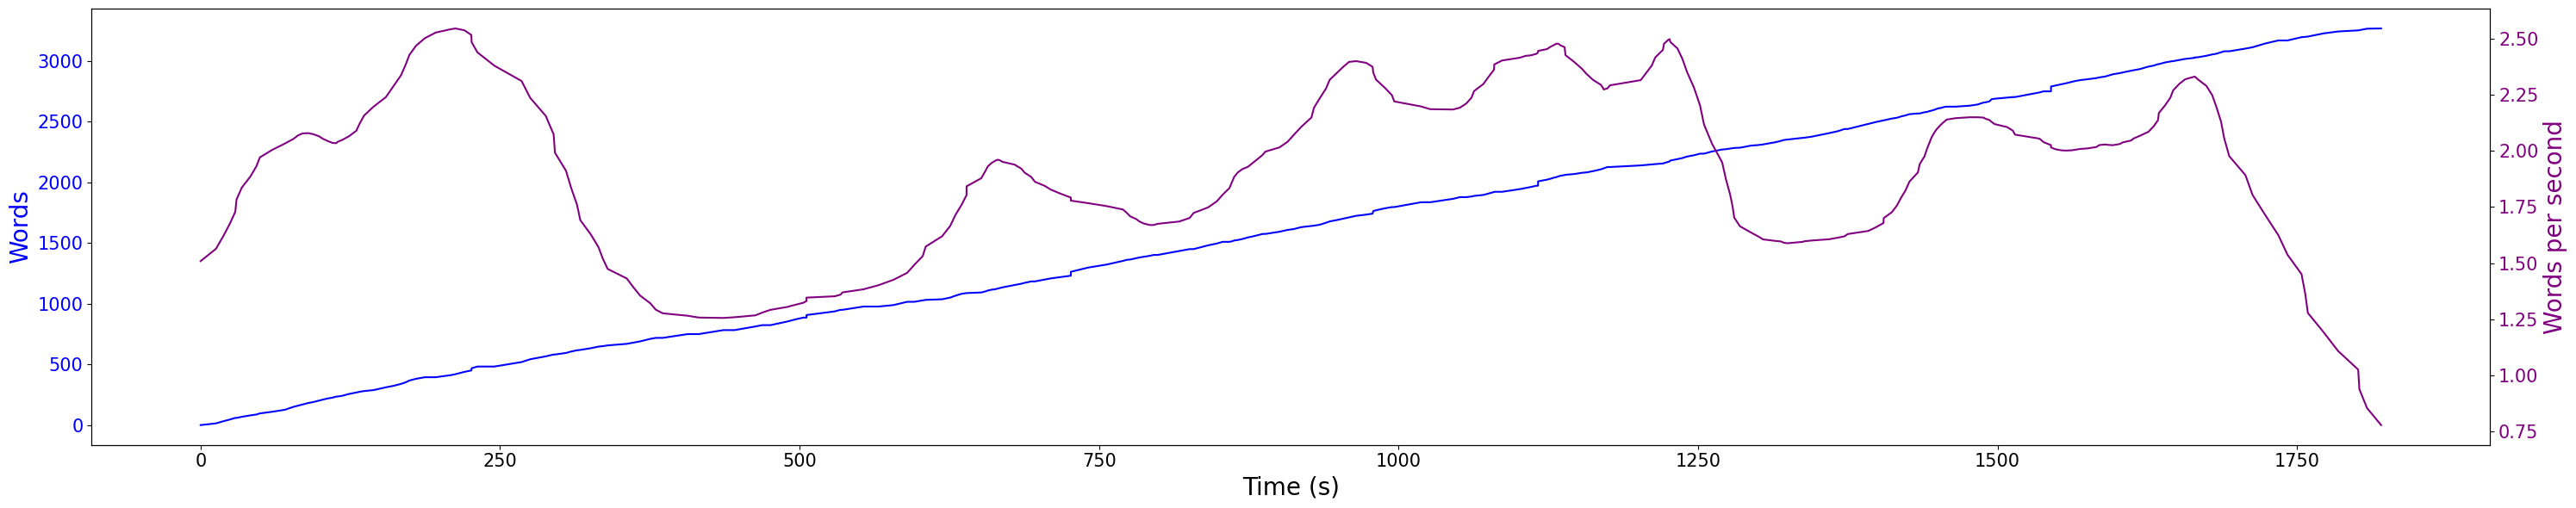

In [78]:
plot_metrics(words_counter, words_per_second, seconds)